In [1]:
# Aquí cargamos un montón de librerías útiles, nada de preocuparse. Lo usaremos más tarde. 
# Es común añadir la mayoría al inicio, es más claro. 

# Para recolectar los archivos 
import glob  

# Para hacer gráficos
import pylab           as     pl

# ¿Recuerdas Excel? Quizá no. Esta es la versión de "Silicon Valley".
import pandas          as     pd

# No harás ciencia sin esta librería.
import numpy           as     np

# Más gráficos. 
from   matplotlib      import pyplot as plt

# Hablaremos de esto más tarde.
from   scipy           import stats

# Un par de cosas útiles para trabajar con datos en astronomía.
from   astropy.table   import Table, join, vstack

#Si sabes la posición de una galaxia de DESI, ¡hagamos una foto de ella!
from   tools.legacy    import cutout

# *Instrumento espectroscópico de energía oscura*

Hoy, continuamos el legado de [Slipher](https://es.wikipedia.org/wiki/Vesto_Slipher), [Hubble](https://es.wikipedia.org/wiki/Edwin_Hubble), [Vera Rubin](https://es.wikipedia.org/wiki/Vera_Rubin) et al. con el estudio DESI de *30 millones* de galaxias. ¡Eso es mucho más que las 24 originales de Hubble!

![title](images/kittpeak.jpg)

Para obtener tantas, necesitamos un telescopio lo suficientemente grande para observar galaxias muy débiles. Con un espejo de 4 m de diámetro, el telescopio Mayall en Kitt Peak es perfecto:

![title](images/desi_mayall.jpg)

Cómo hizo Hubble una vez, también necesitamos observadores que manejen el telescopio por nosotros. Dentro de DESI, todo el mundo tiene su turno en esto (¡seas un experto o no!). Aquí está [Satya](https://satyagontcho.space/) en la sala de control mostrándonos cómo

![alt](images/satya.jpg)

¡Este puedes ser tú algún día! Desde el telescopio, nuestros datos parecen bastante irreconocibles:

![title](images/spectra2D.png)

Aquí estás viendo la luz de 500 fibras ópticas (cada una recolectando la luz de una galaxia) empaquetadas en un CCD. Los arcos horizontales corresponden a una longitud de onda dada, y los arcos brillantes corresponden a líneas brillantes del cielo, ¡una completa molestia!

Los trazos aparentemente aleatorios son rayos cósmicos, detecciones de partículas de alta energía generadas dentro de la atmósfera.

Necesitamos calibrar y limpiar cuidadosamente estas imágenes para recuperar la luz de la galaxia que realmente nos importa. Supongamos que algunas personas inteligentes ya han hecho esto por nosotros, y miremos las imágenes limpias de la luz de algunas galaxias DESI.

También buscaremos agregar algunos marcadores que indiquen las líneas fuertes del hidrógeno (que aprendimos anteriormente) en algunos espectros de cuásares de DESI.

In [2]:
def Rydberg(n, m):
    # Longitud de onda en el vacío del Hidrógeno [nanometros]. Ve la INTRO. 
    result = 1.096e-2 * (1. / n / n - 1. / m / m)
    return 1. / result

In [3]:
# Línea de Lyman-alfa del Hidrógeno.
Lya        = 10. * Rydberg(1, 2)

# La serie de Balmer del Hidrógeno.
Balmers    = 10. * np.array([Rydberg(2, m) for m in np.arange(6, 3, -1)])
Balmers

array([4105.83941606, 4344.80361488, 4866.18004866])

Ahora vamos a seleccionar un tipo de galaxia de DESI (pensamos en las galaxias como diferentes _trazadores_ de la materia oscura). Comenzaremos con los cuásares, QSO, que se explicarán más adelante. Al final del cuaderno, tendrás la oportunidad de seleccionar entre los demás.

Para tu deleite visual, tienes cualquiera de las siguientes

- MWS: EL censo de la Vía Láctea (The Milky Way Survey), un subconjunto de objetivos que intentan atrapar estrellas y [enanas blancas](https://es.wikipedia.org/wiki/Enana_blanca).
- BGS: El censo de galaxias brillantes (The Bright Galaxy Survey), algunas de las galaxias más brillantes y bonitas del censo DESI.
- LRG: El censo de Galaxias rojas (Luminous Red Galaxy), muy rojo, muy luminoso (¡los astrónomos no suelen ser tan creativos!). [Aprox. 6 años de edad y con estrellas de $10^{11}$ veces la masa del Sol.](https://academic.oup.com/mnras/article/377/2/787/1038423).
- ELG: Galaxias de líneas de emisión (Emission line galaxy), con su propio cuaderno: DesigningDESI.ipynb.

In [4]:
# Reemplaza ['qso'] por cualquiera de los otros tipos ['mws'], ['bgs'], ['lrg'], ['elg'], ['qso'] aquí. 
tracers     = ['qso'] 

Ok, primero necesitamos cargar los datos que necesitamos. Los paquetes anteriores son muy útiles para esto. Ponlo a prueba, rompelo
y mira lo que hay ahí!

In [8]:
# Aquí creamos tablas vacías que posteriormente rellenaremos con datos de los desplazamientos al rojo (redshift) de las galaxias, y sus espectros. 
redshifts   = Table()
spectra     = Table()

#DESI observa un "tile" de 5000 galaxias al mismo tiempo. Necesitamos saber el número de ID que le corresponde al tile correspondiente
#de los objetivos que queremos 
tiles       = {'mws': 66003, 'bgs': 66003, 'elg': 67230, 'lrg': 68002, 'qso': 68002}

#Indicamos todos los archivos se encuentran en la carpeta student_andes, y empiezan con, por ejemplo, "zbest-"
rfiles      = glob.glob('../student_andes/zbest-*')
sfiles      = glob.glob('../student_andes/coadd-*')

for tracer in tracers:
  # Construimos el nombre del archivo para este trazador y tile.
    rfile     = '../student_andes/zbest-{}-{}-20200315.fits'.format(tracer, tiles[tracer])    
  
  # Cargamos la información de los desplazamientos al rojo para este archivo y trazador.  
    redshifts = vstack((redshifts, Table.read(rfile)))

  # Lo mismo, pero para su espectro.
    sfile     = '../student_andes/coadd-{}-{}-20200315.fits'.format(tracer, tiles[tracer]) 
    spectra   = vstack((spectra, Table.read(sfile)))
    
print('Número de {} galaxias disponibles: {:d}'.format(tracers[0], len(redshifts)))

Número de qso galaxias disponibles: 5


Recuerda, en Python todo es un objeto, por lo que tiene muchas formas de preguntarle a cualquier cosa qué puede hacer. Intenta escribir 'rfiles?', 'Print (rfiles)', 'rfiles.TAB' en una nueva celda para ver qué puede hacer este objeto. TAB significa que terminas con la tecla TAB (-->|), esto abrirá un cuadro que te indicará los métodos disponibles para el objeto, las cosas que puedes pedirle. P.ej. rfiles.append, al que puede preguntar: 'rfiles.append?' y así. Puedes probar lo mismo con la tabla de corrimientos al rojo, ¡que tendrá muchas más opciones!

Veamos qué obtuvimos en los desplazamientos al rojo. Tendremos cinco filas, una para cada galaxia. Su posición en el cielo, brillo en varias longitudes de onda, tipo de galaxia y número de identificación.

In [9]:
redshifts

TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,SPECTYPE,SUBTYPE,DELTACHI2,FLUX_G,FLUX_R,FLUX_Z,CMX_TARGET,TARGET_RA,TARGET_DEC
int64,float64,float64,float64,float64,int64,bytes6,bytes20,float64,float32,float32,float32,int64,float64,float64
35185923939371431,11016.900862008333,0.0003265550498036014 .. 0.0,2.1337630727260914,0.00013205139345019885,0,QSO,,5860.220424488187,2.5460253,3.1282206,6.450677,54043195528452129,201.80667962268615,6.729774250640312
35185923947758947,21945.633102953434,0.0004955295761302617 .. 0.0,3.0785927158659323,0.00016631319919794678,0,QSO,,11827.31509694457,8.932832,12.4369755,12.0257435,36028797018968097,202.25254229517117,6.691848069124624
35185935939273277,15432.242701277137,0.0004224146530610961 .. 0.0,2.3164113479186756,0.00041214508701321547,0,QSO,,6832.880943790078,4.761269,5.188889,10.378841,54043195528452129,201.75151932056085,7.151470635471182
35185935939275605,13586.427393898368,0.0012699971991643312 .. 0.0,1.14930669628165,0.00011914618492830202,0,QSO,,5283.966160789132,12.528511,15.657297,14.882251,36028797018968097,201.86545000766887,7.2589693081721665
35185935947662300,10059.80414417386,0.0015397448797003833 .. 0.0,1.1643281636101708,7.44466154972391e-05,0,QSO,,7105.9863316342235,10.1635685,11.986815,12.02004,36028797018968064,202.33753792617628,7.177549027087691


Ahora, usaremos la tabla de espectros para hacer un gráfico de la luz de la galaxia.

Text(0.5, 0.91, 'QSO Trazadores')

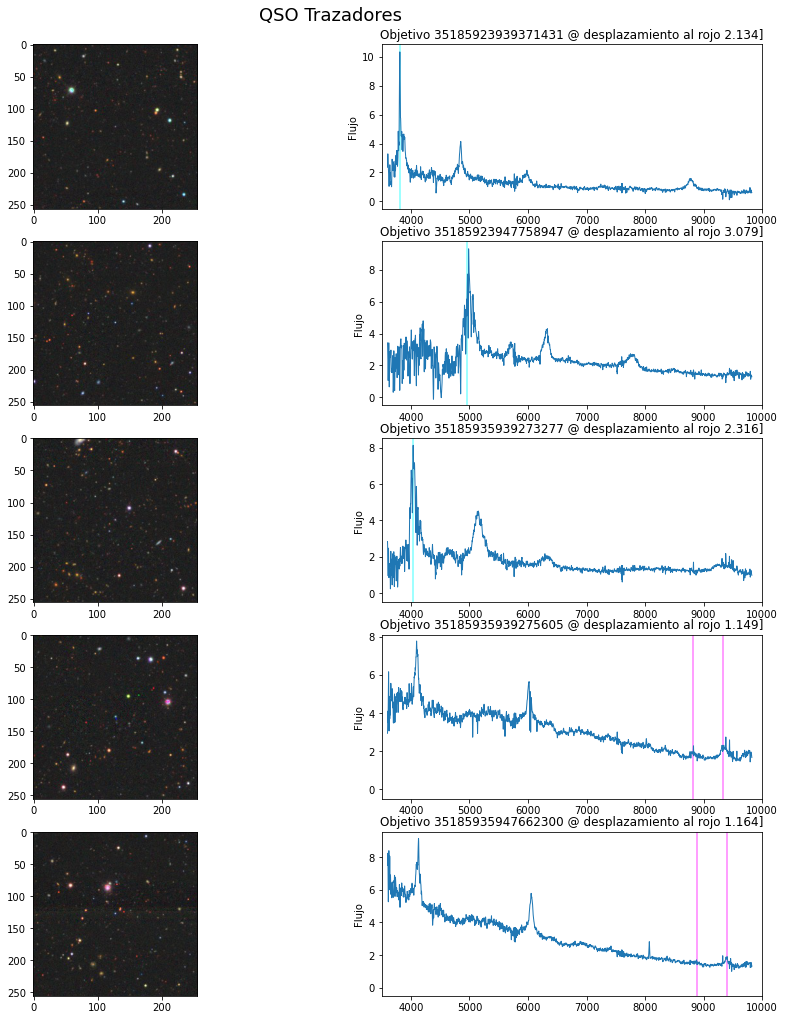

In [10]:
ngal       = 5

# Hace la distribución de los gráficos.
fig, axes  = plt.subplots(ngal, 2, figsize=(15., 3.5 * ngal))

for i, tid in enumerate(redshifts['TARGETID'][:ngal]):
  redshift = redshifts['Z'][i]

  # Añade una línea vertical. Aquí para mostrar la linea de Lyman-alfa.
  axes[i,1].axvline((1. + redshift) * Lya, c='cyan', alpha=0.5)

  # Añade las líneas de Balmer. 
  for balmer in Balmers:
    axes[i,1].axvline((1. + redshift) * balmer, c='magenta', alpha=0.5)      
    
  # ¡Finalmente, grafica el espectro de la galaxia!
  axes[i,1].plot(spectra['WAVELENGTH'], spectra['TARGET{:d}'.format(tid)], lw=1)
  
  # Añade un título.
  axes[i,1].set_title('Objetivo {} @ desplazamiento al rojo {:.3f}]'.format(tid, redshift))

  # Define los límites de los ejes. 
  axes[i,1].set_xlim(3.5e3, 1.e4)
  axes[i,1].set_ylim(bottom=-0.5)

  axes[i,1].set_ylabel('Flujo')

  # Añade una foto de cada galaxia.
  url = cutout(axes[i,0], redshifts['TARGET_RA'][i], redshifts['TARGET_DEC'][i])

fig.suptitle('{} Trazadores'.format(tracers[0].upper()), fontsize=18, y=0.91)

Observa cómo las líneas de hidrógeno que vemos son muy amplias. Esto se debe a que el Hidrógeno se está moviendo rápidamente dentro de este tipo de galaxia, conocida como Cuásar (Quasar) u "Objeto cuasi-estelar". ¡Están muy distantes, sin embargo son muy brillantes, debido a que la materia se acumula en un gran pozo negro en su centro! Consulta [aquí](https://es.wikipedia.org/wiki/Cuásar) para obtener más detalles.

Ahora es tu turno, prueba a cambiar tracers = ['qso'] a tracers = ['lrg'] en la celda [9] de arriba y vuelve a ejecutar las celdas de arriba para rehacer estos gráficos para un tipo diferente de galaxia. Recuerda, necesitas presionar shift-return para evaluar una celda. ¿Qué notas que es diferente entre las diferentes galaxias trazadoras y sus colores?

Ahora que eres un experto, ¿puedes averiguar qué líneas además del hidrógeno están presentes aquí (y trazarlas)?
Puedes probar la lista [aquí](http://classic.sdss.org/dr6/algorithms/linestable.html) para comenzar.